<a href="https://colab.research.google.com/github/ViktoryLoktionova/dl_nlp_ag_news/blob/main/dl_nlp_ag_news.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, MaxPooling1D, Conv1D, GlobalMaxPooling1D, Dropout, LSTM, GRU
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
num_words = 10000
max_news_len = 30
nb_classes = 4

In [9]:
!wget https://github.com/mhjabreel/CharCnn_Keras/raw/master/data/ag_news_csv/train.csv

--2021-11-15 07:47:57--  https://github.com/mhjabreel/CharCnn_Keras/raw/master/data/ag_news_csv/train.csv
Resolving github.com (github.com)... 52.69.186.44
Connecting to github.com (github.com)|52.69.186.44|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/train.csv [following]
--2021-11-15 07:47:57--  https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29470338 (28M) [text/plain]
Saving to: ‘train.csv’

train.csv           100%[===================>]  28.10M   138MB/s    in 0.2s    

2021-11-15 07:48:00 (138 MB/s) - ‘train.csv’ saved [29470338/29470338]



In [8]:
!wget https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/test.csv

--2021-11-15 07:47:05--  https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1857427 (1.8M) [text/plain]
Saving to: ‘test.csv.1’

test.csv.1          100%[===================>]   1.77M  --.-KB/s    in 0.07s   

2021-11-15 07:47:05 (25.5 MB/s) - ‘test.csv.1’ saved [1857427/1857427]



In [4]:
!wget https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/classes.txt

--2021-11-15 07:45:10--  https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31 [text/plain]
Saving to: ‘classes.txt’

classes.txt         100%[===================>]      31  --.-KB/s    in 0s      

2021-11-15 07:45:10 (1.57 MB/s) - ‘classes.txt’ saved [31/31]



In [5]:
!ls

classes.txt  sample_data  test.csv


In [6]:
!cat classes.txt

World
Sports
Business
Sci/Tech


In [ ]:
!head train.csv

In [70]:
!head test.csv

"3","Fears for T N pension after talks","Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul."
"4","The Race is On: Second Private Team Sets Launch Date for Human Spaceflight (SPACE.com)","SPACE.com - TORONTO, Canada -- A second\team of rocketeers competing for the  #36;10 million Ansari X Prize, a contest for\privately funded suborbital space flight, has officially announced the first\launch date for its manned rocket."
"4","Ky. Company Wins Grant to Study Peptides (AP)","AP - A company founded by a chemistry researcher at the University of Louisville won a grant to develop a method of producing better peptides, which are short chains of amino acids, the building blocks of proteins."
"4","Prediction Unit Helps Forecast Wildfires (AP)","AP - It's barely dawn when Mike Fitzpatrick starts his shift with a blur of colorful maps, figures and endless charts, but already he knows what the day will bring. Lightning wil

In [71]:
!wc -l train.csv
!wc -l test.csv

120000 train.csv
7600 test.csv


Загружаем данные в память

In [13]:
train = pd.read_csv('train.csv', 
                    header=None, 
                    names=['class', 'title', 'text'])

In [14]:
train

,class,title,text
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."
...,...,...,...
119995,1,Pakistan's Musharraf Says Won't Quit as Army C...,KARACHI (Reuters) - Pakistani President Perve...
119996,2,Renteria signing a top-shelf deal,Red Sox general manager Theo Epstein acknowled...
119997,2,Saban not going to Dolphins yet,The Miami Dolphins will put their courtship of...
119998,2,Today's NFL games,PITTSBURGH at NY GIANTS Time: 1:30 p.m. Line: ...


In [15]:
news = train['text']
news[:5]

0    Reuters - Short-sellers, Wall Street's dwindli...
1    Reuters - Private investment firm Carlyle Grou...
2    Reuters - Soaring crude prices plus worries\ab...
3    Reuters - Authorities have halted oil export\f...
4    AFP - Tearaway world oil prices, toppling reco...
Name: text, dtype: object

In [16]:
y_train = utils.to_categorical(train['class'] - 1, nb_classes)

In [17]:
y_train

array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]], dtype=float32)

Токенизация текста

In [18]:
news[:5]

0    Reuters - Short-sellers, Wall Street's dwindli...
1    Reuters - Private investment firm Carlyle Grou...
2    Reuters - Soaring crude prices plus worries\ab...
3    Reuters - Authorities have halted oil export\f...
4    AFP - Tearaway world oil prices, toppling reco...
Name: text, dtype: object

Создаем токенизатор Keras

In [19]:
tokenizer= Tokenizer(num_words=num_words)

Обучаем токенизатор на новостях

In [20]:
tokenizer.fit_on_texts(news)

Просматриваем словарь токенизатора

In [21]:
tokenizer.word_index

{'the': 1,
 'a': 2,
 'to': 3,
 'of': 4,
 'in': 5,
 'and': 6,
 'on': 7,
 'for': 8,
 '39': 9,
 's': 10,
 'that': 11,
 'with': 12,
 'as': 13,
 'its': 14,
 'at': 15,
 'said': 16,
 'is': 17,
 'by': 18,
 'it': 19,
 'has': 20,
 'new': 21,
 'an': 22,
 'from': 23,
 'reuters': 24,
 'his': 25,
 'will': 26,
 'was': 27,
 'after': 28,
 'have': 29,
 'be': 30,
 'their': 31,
 'two': 32,
 'are': 33,
 'us': 34,
 'over': 35,
 'quot': 36,
 'year': 37,
 'first': 38,
 'ap': 39,
 'he': 40,
 'but': 41,
 'gt': 42,
 'lt': 43,
 'this': 44,
 'more': 45,
 'monday': 46,
 'wednesday': 47,
 'one': 48,
 'tuesday': 49,
 'up': 50,
 'thursday': 51,
 'company': 52,
 'inc': 53,
 'friday': 54,
 'world': 55,
 'than': 56,
 'u': 57,
 '1': 58,
 'last': 59,
 'they': 60,
 'york': 61,
 'yesterday': 62,
 'against': 63,
 'about': 64,
 'who': 65,
 'not': 66,
 'were': 67,
 'into': 68,
 'out': 69,
 'three': 70,
 'been': 71,
 'president': 72,
 '2': 73,
 'had': 74,
 'million': 75,
 'corp': 76,
 'oil': 77,
 'when': 78,
 'week': 79,
 'time'

Преобразуем новости в числовое представление

In [23]:
sequences = tokenizer.texts_to_sequences(news)


In [24]:
index = 1
print(news[index])
print(sequences[index])

Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.
[24, 863, 751, 371, 93, 84, 20, 2, 3916, 8, 453, 431, 6, 1308, 2799, 5, 1, 549, 237, 20, 3528, 2002, 14, 8267, 7, 216, 314, 4, 1, 131]


In [ ]:
tokenizer.word_index['investment']

Ограничиваем длину новостей

In [26]:
x_train = pad_sequences(sequences, maxlen = max_news_len)

In [27]:
x_train[:5]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,   24,  758, 7851,  433,
        5786, 2861,    4, 5916,   33, 3642,  831,  432],
       [  24,  863,  751,  371,   93,   84,   20,    2, 3916,    8,  453,
         431,    6, 1308, 2799,    5,    1,  549,  237,   20, 3528, 2002,
          14, 8267,    7,  216,  314,    4,    1,  131],
       [  24, 2199,  463,  105, 1568, 1484,   64,    1,  397,    6,    1,
        1026,    8,  317,   33,  178,    3, 6377,   35,    1,  311,  131,
          99,   79,  189,    1, 6120,    4,    1, 1068],
       [   0,   24,  713,   29, 5142,   77, 3549, 7993,   23,    1,  737,
        3199,    5,  493,  106,   28, 1402,  573,    2,  825, 2601,   90,
         760, 2559,   22,   77,  292,   16,    7,   97],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,  165,
          55,   77,  105, 8851, 1776,    6, 8268, 3454,    2,   21,  343,
        3036,   70,  266,  151, 

Сверточная нейронная сеть

In [28]:
model_cnn = Sequential()
model_cnn.add(Embedding(num_words, 32, input_length=max_news_len))
model_cnn.add(Conv1D(250, 5, padding='valid', activation = 'relu'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dense(4, activation='softmax'))

In [29]:
model_cnn.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [30]:
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 32)            320000    
                                                                 
 conv1d (Conv1D)             (None, 26, 250)           40250     
                                                                 
 global_max_pooling1d (Globa  (None, 250)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 128)               32128     
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 392,894
Trainable params: 392,894
Non-trainable params: 0
__________________________________________________

In [63]:
model_cnn_save_path = 'best_model_cnn.h5'
checkpoint_callback_cnn = ModelCheckpoint(model_cnn_save_path, 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

In [64]:
history_cnn = model_cnn.fit(x_train,
                            y_train,
                            epochs = 5,
                            batch_size = 128,
                            validation_split = 0.1,
                            callbacks=[checkpoint_callback_cnn])

Epoch 1/5
844/844 [==============================] - ETA: 0s - loss: 0.0589 - accuracy: 0.9818
Epoch 00001: val_accuracy improved from -inf to 0.86833, saving model to best_model_cnn.h5
844/844 [==============================] - 8s 9ms/step - loss: 0.0589 - accuracy: 0.9818 - val_loss: 0.5258 - val_accuracy: 0.8683
Epoch 2/5
841/844 [============================>.] - ETA: 0s - loss: 0.0420 - accuracy: 0.9876
Epoch 00002: val_accuracy did not improve from 0.86833
844/844 [==============================] - 8s 10ms/step - loss: 0.0421 - accuracy: 0.9875 - val_loss: 0.6051 - val_accuracy: 0.8668
Epoch 3/5
842/844 [============================>.] - ETA: 0s - loss: 0.0350 - accuracy: 0.9904
Epoch 00003: val_accuracy did not improve from 0.86833
844/844 [==============================] - 8s 10ms/step - loss: 0.0350 - accuracy: 0.9904 - val_loss: 0.6569 - val_accuracy: 0.8645
Epoch 4/5
843/844 [============================>.] - ETA: 0s - loss: 0.0294 - accuracy: 0.9915
Epoch 00004: val_accurac

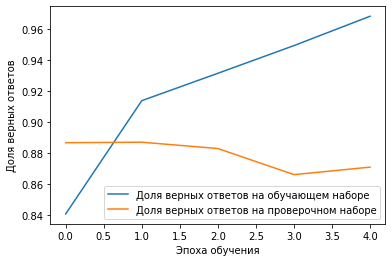

In [33]:
plt.plot(history_cnn.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_cnn.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

Cеть LSTM

In [34]:
model_lstm = Sequential()
model_lstm.add(Embedding(num_words, 32, input_length=max_news_len))
model_lstm.add(LSTM(16))
model_lstm.add(Dense(4, activation = 'softmax'))

In [44]:
model_lstm.compile(optimizer = 'adam',
                   loss = 'categorical_crossentropy',
                   metrics=['accuracy'])

In [37]:
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 30, 32)            320000    
                                                                 
 lstm (LSTM)                 (None, 16)                3136      
                                                                 
 dense_2 (Dense)             (None, 4)                 68        
                                                                 
Total params: 323,204
Trainable params: 323,204
Non-trainable params: 0
_________________________________________________________________


In [38]:
model_lstm_save_path = 'best_model_lstm.h5'
checkpoint_callback_lstm = ModelCheckpoint(model_lstm_save_path,
                                           monitor = 'val_accuracy',
                                           save_best_only=True,
                                           verbose=1)


In [45]:
history_lstm = model_lstm.fit(x_train, 
                              y_train, 
                              epochs=5,
                              batch_size=128,
                              validation_split=0.1,
                              callbacks=[checkpoint_callback_lstm])

Epoch 1/5
844/844 [==============================] - ETA: 0s - loss: 0.4952 - accuracy: 0.8283
Epoch 00001: val_accuracy improved from -inf to 0.88658, saving model to best_model_lstm.h5
844/844 [==============================] - 13s 12ms/step - loss: 0.4952 - accuracy: 0.8283 - val_loss: 0.3334 - val_accuracy: 0.8866
Epoch 2/5
841/844 [============================>.] - ETA: 0s - loss: 0.2752 - accuracy: 0.9107
Epoch 00002: val_accuracy improved from 0.88658 to 0.89058, saving model to best_model_lstm.h5
844/844 [==============================] - 9s 11ms/step - loss: 0.2752 - accuracy: 0.9107 - val_loss: 0.3110 - val_accuracy: 0.8906
Epoch 3/5
840/844 [============================>.] - ETA: 0s - loss: 0.2366 - accuracy: 0.9229
Epoch 00003: val_accuracy did not improve from 0.89058
844/844 [==============================] - 9s 11ms/step - loss: 0.2366 - accuracy: 0.9229 - val_loss: 0.3305 - val_accuracy: 0.8859
Epoch 4/5
843/844 [============================>.] - ETA: 0s - loss: 0.2116 

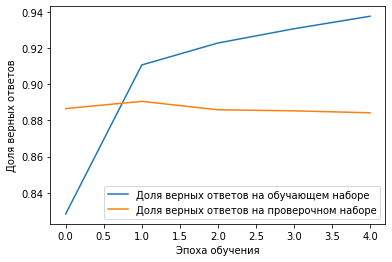

In [46]:
plt.plot(history_lstm.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_lstm.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

Cеть GRU

In [47]:
model_gru = Sequential()
model_gru.add(Embedding(num_words, 32, input_length=max_news_len))
model_gru.add(GRU(16))
model_gru.add(Dense(4, activation='softmax'))

In [48]:
model_gru.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [49]:
model_gru.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 30, 32)            320000    
                                                                 
 gru (GRU)                   (None, 16)                2400      
                                                                 
 dense_3 (Dense)             (None, 4)                 68        
                                                                 
Total params: 322,468
Trainable params: 322,468
Non-trainable params: 0
_________________________________________________________________


In [50]:
model_gru_save_path = 'best_model_gru.h5'
checkpoint_callback_gru = ModelCheckpoint(model_gru_save_path, 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

In [51]:
history_gru = model_gru.fit(x_train, 
                              y_train, 
                              epochs=5,
                              batch_size=128,
                              validation_split=0.1,
                              callbacks=[checkpoint_callback_gru])

Epoch 1/5
843/844 [============================>.] - ETA: 0s - loss: 0.5646 - accuracy: 0.7927
Epoch 00001: val_accuracy improved from -inf to 0.88183, saving model to best_model_gru.h5
844/844 [==============================] - 12s 12ms/step - loss: 0.5646 - accuracy: 0.7927 - val_loss: 0.3363 - val_accuracy: 0.8818
Epoch 2/5
841/844 [============================>.] - ETA: 0s - loss: 0.2821 - accuracy: 0.9077
Epoch 00002: val_accuracy improved from 0.88183 to 0.88700, saving model to best_model_gru.h5
844/844 [==============================] - 9s 11ms/step - loss: 0.2822 - accuracy: 0.9077 - val_loss: 0.3200 - val_accuracy: 0.8870
Epoch 3/5
843/844 [============================>.] - ETA: 0s - loss: 0.2422 - accuracy: 0.9203
Epoch 00003: val_accuracy improved from 0.88700 to 0.89042, saving model to best_model_gru.h5
844/844 [==============================] - 9s 11ms/step - loss: 0.2421 - accuracy: 0.9202 - val_loss: 0.3166 - val_accuracy: 0.8904
Epoch 4/5
842/844 [====================

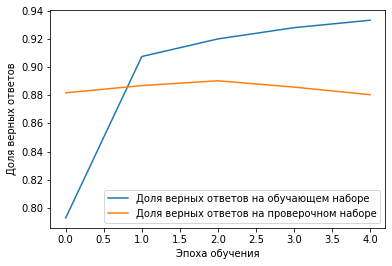

In [52]:
plt.plot(history_gru.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_gru.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

Загружаем набор данных для тестирования

In [72]:
test = pd.read_csv('test.csv',
                   header = None,
                   names = ['class', 'title', 'text'])

In [54]:
test

,class,title,text
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...
1,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o..."
2,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...
3,4,Prediction Unit Helps Forecast Wildfires (AP),AP - It's barely dawn when Mike Fitzpatrick st...
4,4,Calif. Aims to Limit Farm-Related Smog (AP),AP - Southern California's smog-fighting agenc...
...,...,...,...
7595,1,Around the world,Ukrainian presidential candidate Viktor Yushch...
7596,2,Void is filled with Clement,With the supply of attractive pitching options...
7597,2,Martinez leaves bitter,Like Roger Clemens did almost exactly eight ye...
7598,3,5 of arthritis patients in Singapore take Bext...,SINGAPORE : Doctors in the United States have ...


In [73]:
test_sentences = tokenizer.texts_to_sequences(test['text'])

In [74]:
x_test = pad_sequences(sequences, maxlen = max_news_len)

In [57]:
x_test[:5]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,   24,  758, 7851,  433,
        5786, 2861,    4, 5916,   33, 3642,  831,  432],
       [  24,  863,  751,  371,   93,   84,   20,    2, 3916,    8,  453,
         431,    6, 1308, 2799,    5,    1,  549,  237,   20, 3528, 2002,
          14, 8267,    7,  216,  314,    4,    1,  131],
       [  24, 2199,  463,  105, 1568, 1484,   64,    1,  397,    6,    1,
        1026,    8,  317,   33,  178,    3, 6377,   35,    1,  311,  131,
          99,   79,  189,    1, 6120,    4,    1, 1068],
       [   0,   24,  713,   29, 5142,   77, 3549, 7993,   23,    1,  737,
        3199,    5,  493,  106,   28, 1402,  573,    2,  825, 2601,   90,
         760, 2559,   22,   77,  292,   16,    7,   97],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,  165,
          55,   77,  105, 8851, 1776,    6, 8268, 3454,    2,   21,  343,
        3036,   70,  266,  151, 

In [59]:
y_test = utils.to_categorical(test['class'] - 1, nb_classes)

In [60]:
y_test

array([[0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]], dtype=float32)

Оцениваем качество работы сети на тестовом наборе данных

Одномерная сверточная сеть

In [65]:
model_cnn.load_weights(model_cnn_save_path)

In [ ]:
model_cnn.evaluate(x_test, y_test, verbose=1)

In [68]:
model_lstm.load_weights(model_lstm_save_path)

In [ ]:
model_lstm.evaluate(x_test, y_test, verbose=1)

In [ ]:
model_gru.load_weights(model_gru_save_path)

In [ ]:
model_gru.evaluate(x_test, y_test, verbose=1)